In [1]:
# import some common libraries
import numpy as np
import os, json, cv2, random

import os
import json
import pandas as pd
from pycocotools.coco import COCO
from tqdm import tqdm  # Import tqdm for progress bar
import numpy as np  # Ensure numpy is imported for mask operations
import cv2

from matplotlib import pyplot as plt

import pycocotools.mask as mask_util

from typing import List

import copy

# Path Management

In [2]:
# Modify base_dir to the original data directory
base_dir = "./turtles-data/data"

# Modify the prediction path to the actual prediction json file path
pred_path = "./output/pred_res/output_mask2former/coco_instances_results.json"

# Loading prediction result as prepare ground truth

In [3]:
"""
Load prediction result
"""
with open(pred_path, 'r') as f:
    res = json.load(f)

In [4]:
"""
Load ground truth mask for test set
"""
def create_split_coco(img_ids, coco):
    # Create a COCO dataset split
    split_annotations = {}
    for img_id in tqdm(img_ids, desc="Preprocessing bbox and masks"):
        anns = coco.imgToAnns[img_id]
        for ann in anns:
            split_annotations[ann["id"]] = ann

    # Create new COCO object with processed split annotations
    split_coco = COCO()
    split_coco.dataset = {
        "images": [coco.imgs[img_id] for img_id in img_ids],
        "annotations": list(split_annotations.values()),
        "categories": coco.dataset["categories"]
    }
    split_coco.createIndex()
    return split_coco

annotations_path = os.path.join(base_dir, 'annotations.json')
split_path = os.path.join(base_dir, 'metadata_splits.csv')

# Load the split dataframe
split = pd.read_csv(split_path)

# Load the COCO annotations
coco = COCO(annotations_path)

# Separate the COCO ids into test based on the split DataFrame
test_ids = split[split['split_open'] == 'test']['id'].tolist()
gt_test = create_split_coco(test_ids, coco)

loading annotations into memory...
Done (t=5.71s)
creating index...
index created!


Preprocessing bbox and masks: 100%|██████████| 2308/2308 [00:00<00:00, 122518.78it/s]

creating index...
index created!


# Helper functions / classes
### prepare prediction masks, ground truth masks and IoU computation

In [5]:
from typing import List

class Prediction:
    def __init__(self, predictions: List[dict]) -> None:
        self.preds = self.init_pred_mask(predictions)

    def init_pred_mask(self, predictions):
        preds = {}
        for img_id, instance in tqdm(predictions.items(), desc="Initializing predictions"):
            img_id = int(img_id)
            for cat_id, segm in instance.items():
                cat_id = int(cat_id)
                mask = mask_util.decode(segm)
                # if the image is not regitsered, register the image and instance mask
                if img_id not in preds:
                    preds[img_id] = { cat_id: mask }
                else:
                    # if the image is registered, check whether the instance is registered
                    if cat_id in preds[img_id]:
                        # if yes, take the and operation for masks
                        preds[img_id][cat_id] = np.logical_or(preds[img_id][cat_id], mask)
                    else:
                        # if no, register the instance mask
                        preds[img_id][cat_id] = mask
        
        return preds
    
    def get_mask(self, img_id, cat_id):
        mask = None
        if img_id in self.preds and cat_id in self.preds[img_id]:
            mask = self.preds[img_id][cat_id]

        return mask


def process_ann(anns, coco):
    """
    Process a list of annotations for one image, modifying each instance mask of category 1
    by excluding areas covered by category 2 and category 3 masks.
    
    Args:
        anns (list): List of annotations for a single image.

    Returns:
        list: Updated list of annotations.
    """
    # Initialize combined masks for categories 2 and 3
    combined_cat_2_mask = None
    combined_cat_3_mask = None

    # Combine all masks for categories 2 and 3 to exclude them from each instance of category 1
    for ann in anns:
        mask = coco.annToMask(ann)
        if ann["category_id"] == 2:
            combined_cat_2_mask = mask if combined_cat_2_mask is None else np.logical_or(combined_cat_2_mask, mask)
        elif ann["category_id"] == 3:
            combined_cat_3_mask = mask if combined_cat_3_mask is None else np.logical_or(combined_cat_3_mask, mask)

    # Process each instance of category 1 separately
    for ann in anns:
        if ann["category_id"] == 1:
            # Decode the current category 1 mask
            cat_1_mask = coco.annToMask(ann)

            # Subtract combined masks of categories 2 and 3 from the current category 1 instance
            if combined_cat_2_mask is not None:
                cat_1_mask = np.logical_and(cat_1_mask, np.logical_not(combined_cat_2_mask))
            if combined_cat_3_mask is not None:
                cat_1_mask = np.logical_and(cat_1_mask, np.logical_not(combined_cat_3_mask))

            # Convert modified mask back to RLE format
            cat_1_rle = mask_util.encode(np.asfortranarray(cat_1_mask.astype(np.uint8)))

            # Update segmentation mask for the current annotation
            ann["segmentation"] = cat_1_rle

            # Update bounding box based on the modified mask
            ys, xs = np.where(cat_1_mask)
            if ys.size > 0 and xs.size > 0:
                x_min, y_min, x_max, y_max = xs.min(), ys.min(), xs.max(), ys.max()
                ann["bbox"] = [x_min, y_min, x_max - x_min, y_max - y_min]
            else:
                # Set bbox to empty if mask is empty after processing
                ann["bbox"] = [0, 0, 0, 0]

    return anns

def init_ground_truth(gt_coco):
    gt = {}
    for img_id in tqdm(gt_coco.imgs, desc="Initializing images"):
        gt[img_id] = {}
        anns = gt_coco.imgToAnns[img_id]
        process_ann(anns, gt_coco)

        for cat in [3, 2, 1]:
            ann_ids = gt_coco.getAnnIds(imgIds=img_id, catIds=[cat])
            masks = [gt_coco.annToMask(gt_coco.anns[_id]) for _id in ann_ids]
            
            mask = np.logical_or.reduce(masks)
            gt[img_id][cat] = mask
    return gt
        

def iou(gt_mask, pred_mask):
    """Calculate Intersection over Union (IoU) for two masks."""
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    if union == 0:
        return 0.0
    return intersection / union

def compute_iou(gt, pred):
    results = {}
    for cat_id in [1, 2, 3]:
        results[cat_id] = {}

        for img_id, cats in tqdm(gt.items(), desc=f"Processing cat {cat_id}"):
            gt_mask = cats[cat_id]
            pred_mask = pred.get_mask(img_id,cat_id)
            
            if pred_mask is None:
                pred_mask = np.zeros_like(gt_mask)
                
            results[cat_id][img_id] = iou(gt_mask, pred_mask)
            
    return results

# Prepare ground truth mask and prediction result mask for each category

In [6]:
gt = init_ground_truth(copy.deepcopy(gt_test))
pred = Prediction(res)

Initializing predictions: 100%|██████████| 2308/2308 [00:25<00:00, 92.04it/s]


# Evaluate

In [7]:
eval_result = compute_iou(gt, pred)

Processing cat 3: 100%|██████████| 2308/2308 [00:32<00:00, 71.53it/s]


In [8]:
print("IoU")
print("Turtle: ", np.array(list(eval_result[1].values())).mean())
print("Flippers: ", np.array(list(eval_result[2].values())).mean())
print("Head: ", np.array(list(eval_result[3].values())).mean())

IoU
Turtle:  0.9236473983039004
Flippers:  0.857259824483226
Head:  0.777563519924601


# Analysis performance (IoU) distributions for each category

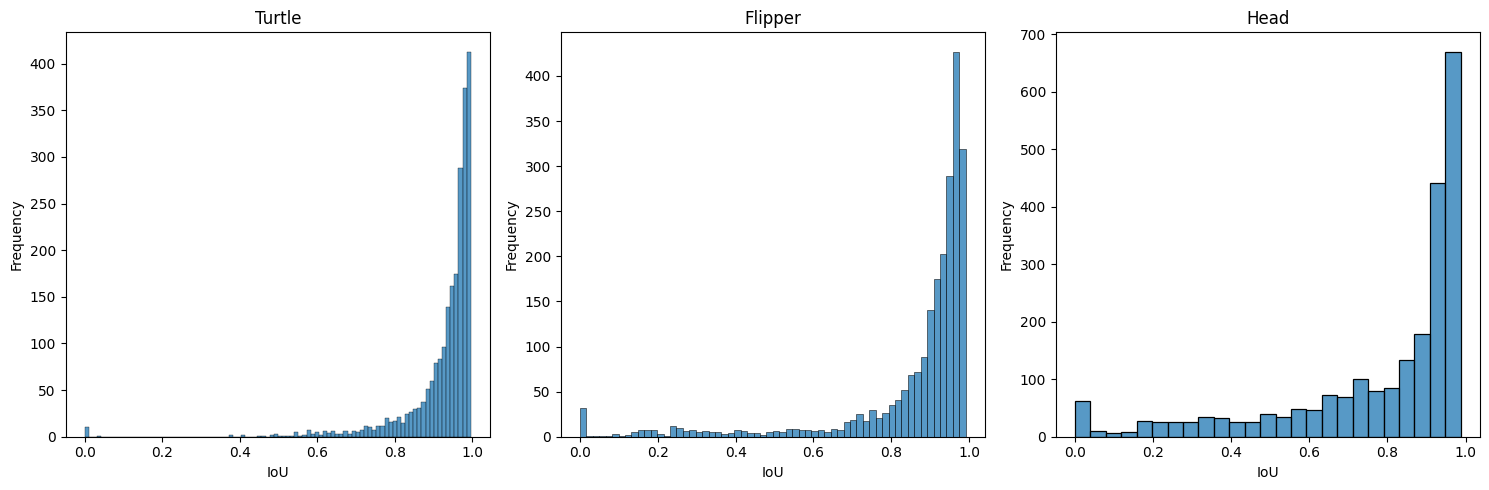

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extracting IoU values for each result
turtle_ious_1 = list(eval_result[1].values())
turtle_ious_2 = list(eval_result[2].values())
turtle_ious_3 = list(eval_result[3].values())

# Creating a 1 row * 3 column grid of histograms
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for eval_result[1]
sns.histplot(turtle_ious_1, ax=axs[0])
axs[0].set_title('Turtle')
axs[0].set_xlabel('IoU')
axs[0].set_ylabel('Frequency')

# Plot for eval_result[2]
sns.histplot(turtle_ious_2, ax=axs[1])
axs[1].set_title('Flipper')
axs[1].set_xlabel('IoU')
axs[1].set_ylabel('Frequency')

# Plot for eval_result[3]
sns.histplot(turtle_ious_3, ax=axs[2])
axs[2].set_title('Head')
axs[2].set_xlabel('IoU')
axs[2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()


# Sort the sample with increasing IoU for each category

In [10]:
turtle_bad_cases = pd.DataFrame(pd.Series(eval_result[1])) \
    .sort_values(0) \
    .reset_index()

turtle_bad_cases['image_path'] = turtle_bad_cases['index'] \
    .apply(lambda x: os.path.join(base_dir, gt_test.imgs[x]['file_name']))

flipper_bad_cases = pd.DataFrame(pd.Series(eval_result[2])) \
    .sort_values(0) \
    .reset_index()

flipper_bad_cases['image_path'] = flipper_bad_cases['index'] \
    .apply(lambda x: os.path.join(base_dir, gt_test.imgs[x]['file_name']))

head_bad_cases = pd.DataFrame(pd.Series(eval_result[3])) \
    .sort_values(0) \
    .reset_index()

head_bad_cases['image_path'] = head_bad_cases['index'] \
    .apply(lambda x: os.path.join(base_dir, gt_test.imgs[x]['file_name']))

In [11]:
# Column "0" is the IoU for that sample of that body part
flipper_bad_cases

,index,0,image_path
0,7578,0.000000,./turtles-data/data/images/t441/owPFsHErHt.JPG
1,8698,0.000000,./turtles-data/data/images/t470/HTBHbxZfIp.jpeg
2,8190,0.000000,./turtles-data/data/images/t468/dNgczBGVof.jpeg
3,8010,0.000000,./turtles-data/data/images/t296/iKqreJMQEX.jpeg
4,5619,0.000000,./turtles-data/data/images/t300/XsgPVEvakY.jpeg
...,...,...,...
2303,7850,0.991173,./turtles-data/data/images/t082/xrZWORtrRZ.jpeg
2304,5463,0.991253,./turtles-data/data/images/t292/sOVIikdPaV.JPG
2305,7970,0.991498,./turtles-data/data/images/t246/wAFXmkOyBY.jpeg
2306,6252,0.991503,./turtles-data/data/images/t333/CKKfEtuvUP.JPG


# Visualize the prediction results vs. ground truth for each category

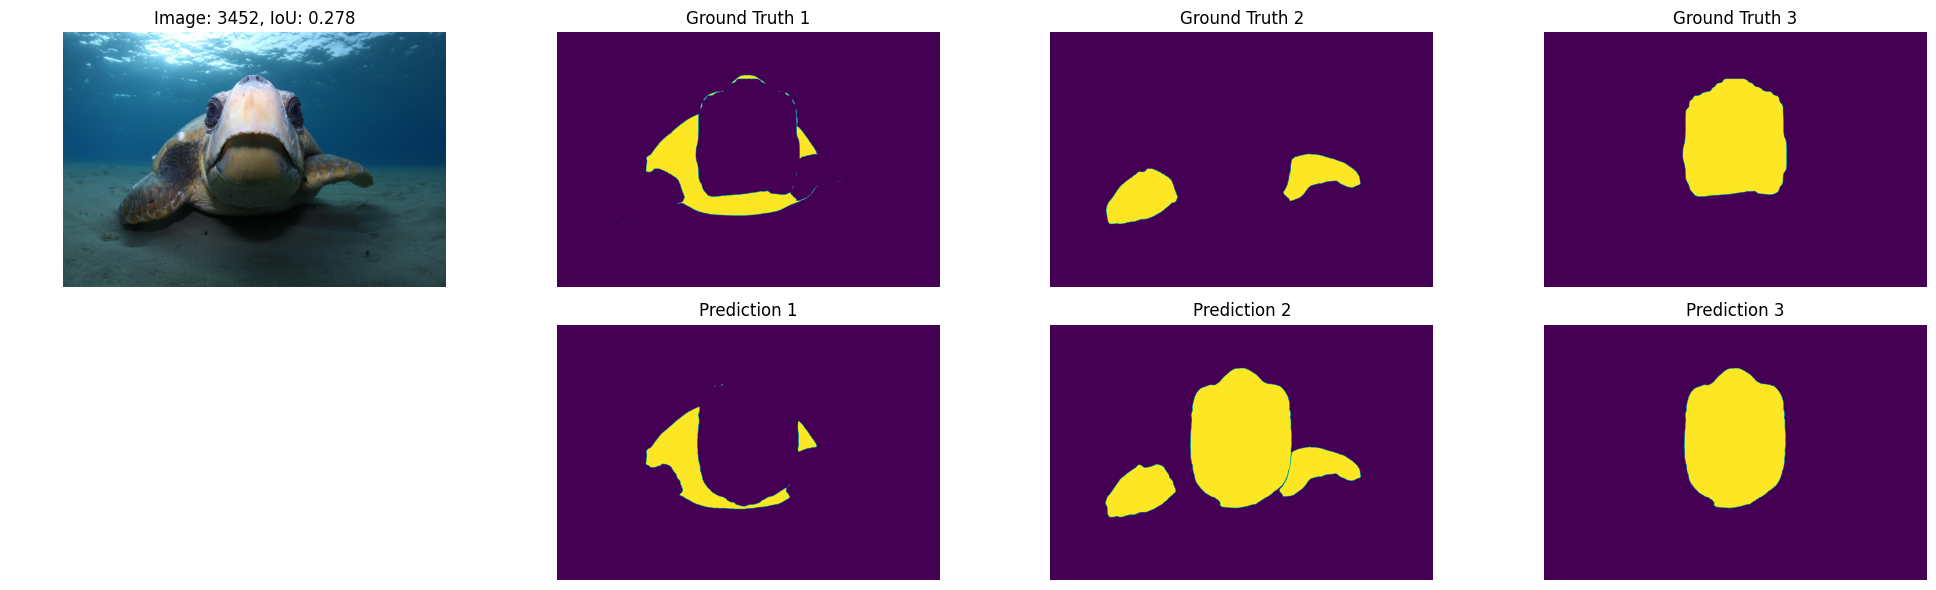

In [12]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

"""Change here to select the case you would like to visualize
"""
case_idx = 100

# Load image and set up the grid
_case = flipper_bad_cases.iloc[case_idx]
idx = _case['index']

img = Image.open(_case['image_path'])

fig, axs = plt.subplots(2, 4, figsize=(20, 6))

# Image at (0, 0)
axs[0, 0].imshow(img)
axs[0, 0].set_title(f'Image: {idx}, IoU: {_case[0]:.3f}')
axs[0, 0].axis('off')

# Ground truth masks at (0, 1), (0, 2), (0, 3)
for i in range(1, 4):
    if i in gt[idx] and isinstance(gt[idx][i], np.ndarray):
        axs[0, i].imshow(gt[idx][i].astype(int))
        axs[0, i].set_title(f'Ground Truth {i}')
    axs[0, i].axis('off')

# Prediction masks at (1, 1), (1, 2), (1, 3)
for i in range(1, 4):
    if i in pred.preds[idx] and isinstance(pred.preds[idx][i], np.ndarray):
        axs[1, i].imshow(pred.preds[idx][i].astype(int))
        axs[1, i].set_title(f'Prediction {i}')
    axs[1, i].axis('off')

# Hide (1, 0) as it is empty
axs[1, 0].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()
